# Import the VGG-19 model

In [1]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(include_top=False,
             weights = 'imagenet') 

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Import Libraries and Helper Functions

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Image Processing and Display

In [4]:
content_image_path = "content.jpg"
style_image_path = "style.jpg"
size = 224

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path) 
    img = img_to_array(img) 
    img = preprocess_input(img)
    return np.expand_dims(img,axis=0) 

In [6]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

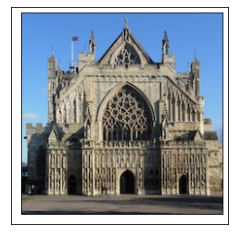

In [7]:
display_image(preprocess_image(content_image_path))

# Content and Style Models

In [8]:
content_layer = 'block5_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

style_layers = [
    'block1_conv1',
    'block3_conv1', 
    'block5_conv1'
    ]

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

# Content Cost

In [9]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

# Gram Matrix

In [10]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1,n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    return G / tf.cast(n, tf.float32)

# Style cost

In [11]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        J_style += current_cost*lam
    
    return J_style

# Training Loop

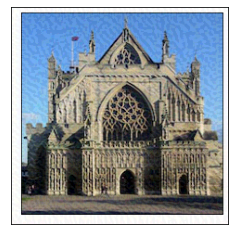

Iteration:1/1, Total Cost:37357705232384.0, Style Cost: 373577056.0, Content Cost: 0.0


In [12]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []
lr = 7.0 
iterations = 1
style_wt = 1e5
content_wt = 1.0

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_image_preprocessed, generated_image)
        J_style = style_cost(style_image_preprocessed, generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

# Plot the Results

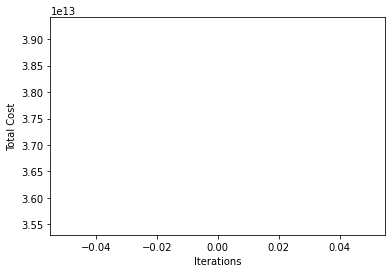

In [13]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [14]:
from PIL import Image
image = Image.fromarray(deprocess(generated_images[-1][0]))

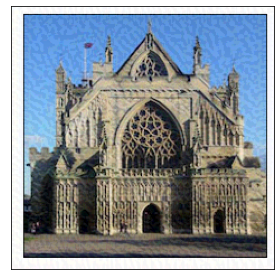

In [15]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('out.png')

In [16]:
def transfer_style(content_image_path, style_image_path):
    content_image_preprocessed = preprocess_image(content_image_path)
    style_image_preprocessed = preprocess_image(style_image_path)
    generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

    generated_images = []
    costs = []
    lr = 7.0 
    iterations = 10
    style_wt = 1e5
    content_wt = 1.0

    optimizer = tf.optimizers.Adam(learning_rate=lr)

    for i in range(iterations):

        with tf.GradientTape() as tape:
            J_content = content_cost(content_image_preprocessed, generated_image)
            J_style = style_cost(style_image_preprocessed, generated_image)
            J_total = content_wt * J_content + style_wt * J_style

        gradients = tape.gradient(J_total, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        costs.append(J_total.numpy())
        
    return generated_image.numpy()

In [17]:
output = transfer_style('content_image.jpg', 'style_image.jpg')

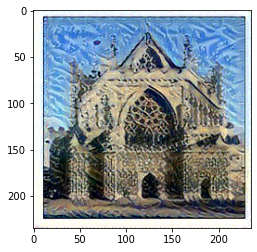

In [18]:
image = Image.fromarray(deprocess(output[0]))
plt.imshow(image)

In [19]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

import base64
import cv2
import time
app = Flask(__name__)
run_with_ngrok(app)   


@app.route("/", methods=['POST'])
def styler():
    output = None
    data = request.get_json()
    decoded1 = base64.decodebytes(bytes(data['content_image'], 'ascii'))
    nparr1 = np.frombuffer(decoded1, np.uint8)
    img_np1 = cv2.imdecode(nparr1, cv2.IMREAD_ANYCOLOR)
    cv2.imwrite('content_image1.jpg', img_np1)

    decoded2 = base64.decodebytes(bytes(data['style_image'], 'ascii'))
    nparr2 = np.frombuffer(decoded2, np.uint8)
    img_np2 = cv2.imdecode(nparr2, cv2.IMREAD_ANYCOLOR)
    cv2.imwrite('style_image1.jpg', img_np2)

    try:
        output = transfer_style('content_image1.jpg', 'style_image1.jpg')
        outimage = Image.fromarray(deprocess(output[0]))
        plt.imshow(outimage)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('output.png')
        time.sleep(1) 
        with open('output.png', 'rb') as f:
            im_b64 = base64.b64encode(f.read())
            
        return im_b64
    except Exception as e:
        print(e)
        return jsonify({'status': 'failure'})

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c1315d35589d.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [21/May/2021 17:35:03] "GET / HTTP/1.1" 405 -
127.0.0.1 - - [21/May/2021 17:35:03] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/May/2021 17:40:02] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:43:25] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:45:32] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:47:03] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:48:21] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:48:49] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:55:15] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:55:48] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 17:57:20] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 18:00:42] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 18:03:49] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 18:05:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 18:06:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2021 18:06:20] "POST / HTTP/1.1" 200 -
